# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author: Amir Rezaie 

**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
## Load necessary packages and instances

import os
import numpy as np
from scipy import ndimage,misc, interpolate
from scipy.ndimage import binary_fill_holes
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import tarfile
import skimage.io
from skimage.filters import median,sobel_v,sobel_h
from skimage.morphology import disk, square, rectangle, opening, closing, binary_closing, skeletonize,dilation,erosion
from skimage import exposure, feature,img_as_float
from skimage.measure import label, regionprops, perimeter
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from statistics import stdev, mean, mode
from sklearn.cluster import KMeans 
from IPython.display import HTML, display
from skimage.segmentation import chan_vese
import random
from skimage.transform import AffineTransform, warp, rotate,SimilarityTransform
data_base_path = os.path.join('../.','data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)


## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization
#### 1.1.1 Loading images

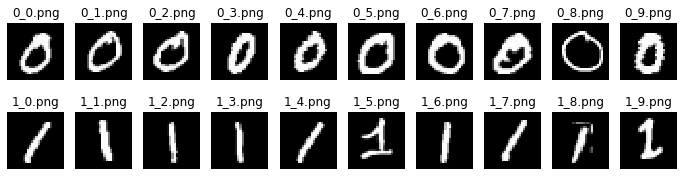

In [3]:
# Load images
data_base_path = os.path.join('../.', 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### 1.1.2 Binary Image

For better recognition of the edges, the images are thresholded and converted to binary, so that the blurry grayish parts are removed.

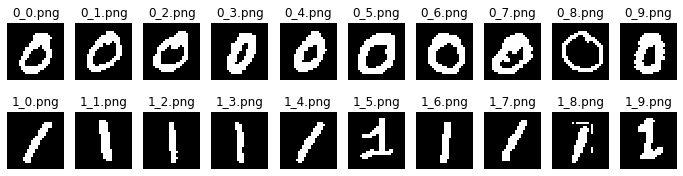

In [4]:
binary_zeros=[]
for im_items in range(len(zeros_im)):
    binary_zeros.append(zeros_im[im_items]>50)
    
binary_ones=[]
for im_items in range(len(ones_im)):
    binary_ones.append(ones_im[im_items]>50)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], binary_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], binary_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### 1.1.3  Morphology Application
A few rounds of morphological methods are applied to the images to remove the unwanted spots in the images.

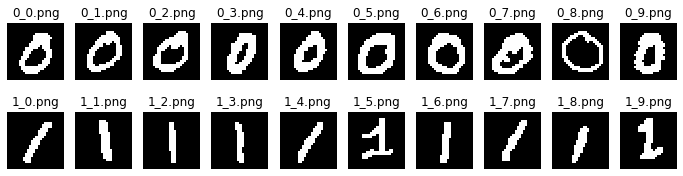

In [5]:
Opbinary_zeros=[]
for im_items in range(len(zeros_im)):
    Opbinary_zeros.append(opening(binary_zeros[im_items], square(1)))

Opbinary_ones=[]
for im_items in range(len(ones_im)):
    Opbinary_ones.append(opening(binary_ones[im_items], square(2)))

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Opbinary_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Opbinary_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
#### 1.2.1 Finding boundary countours
A contour tracking function is defined to find the peripheral contours in the image to be further used for fourier transformations.

In [6]:
def contour_tracking(image):
    img=image.copy()
    for i, row in enumerate(image):
        for j, value in enumerate(row):
            if value == 1:
                start_point=(i,j)
                break
        else:
            continue
        break
    directions = [ 0,  1,  2,
                   7,      3,
                   6,  5,  4]
    dir2idx = dict(zip(directions, range(len(directions))))

    change_j =   [-1,  0,  1, # x or columns
                  -1,      1,
                  -1,  0,  1]

    change_i =   [-1, -1, -1, # y or rows
                   0,      0,
                   1,  1,  1]

    border = []
    chain = []
    curr_point = start_point
    for direction in directions:
        idx = dir2idx[direction]
        new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
        if img[new_point] != 0: # if is ROI
            border.append(new_point)
            chain.append(direction)
            curr_point = new_point
            break

    count = 0
    while curr_point != start_point:
        #figure direction to start search
        b_direction = (direction + 5) % 8 
        dirs_1 = range(b_direction, 8)
        dirs_2 = range(0, b_direction)
        dirs = []
        dirs.extend(dirs_1)
        dirs.extend(dirs_2)
        for direction in dirs:
            idx = dir2idx[direction]
            new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
            if image[new_point] != 0: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break
        if count == 1000: break
        count += 1
    return border

In [7]:
border_zeros=[]

for im_items in range(len(zeros_im)):
    border_zeros.append(contour_tracking(Opbinary_zeros[im_items]))
    
border_ones=[]
for im_items in range(len(ones_im)):
    border_ones.append(contour_tracking(Opbinary_ones[im_items]))

#### 1.2.2 Plotting bounding contours

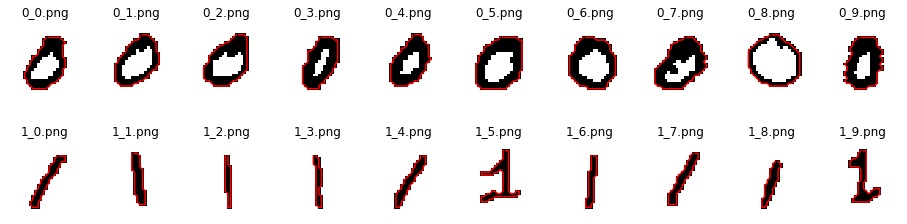

In [8]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(16, 4))
j = 0
for ax, im, nm in zip(axes[0], Opbinary_zeros, zeros_names):
    ax.imshow(im, cmap='Greys')
    ax.plot([i[1] for i in border_zeros[j]], [i[0] for i in border_zeros[j]], 'r')
    ax.axis('off')
    ax.set_title(nm)
    j += 1
k = 0
for ax, im, nm in zip(axes[1], Opbinary_ones, ones_names):
    ax.imshow(im, cmap='Greys')
    ax.plot([i[1] for i in border_ones[k]], [i[0] for i in border_ones[k]], 'r')
    ax.axis('off')
    ax.set_title(nm)
    k += 1

#### 1.2.3 Fourier Transformation

In order to apply Fourier transform to our discrete signals, their length has to be the same. As the length of the boundary data for zeros and ones are not the same, a resampling-interpolation procedure is performed to create signals of the same length.

In [9]:
# Store X and Y coordinates of the boundaries of "ones" and "zeros" in separate lists

X_zeros_total=[]
Y_zeros_total=[]

for im_items in range(len(zeros_im)):
    X_zeros=[]
    Y_zeros=[]
    for border_numbers in range(len(border_zeros[im_items])):
        X_zeros.append(border_zeros[im_items][border_numbers][0])
        Y_zeros.append(border_zeros[im_items][border_numbers][1])
    X_zeros_total.append(X_zeros)
    Y_zeros_total.append(Y_zeros)
    

X_ones_total=[]
Y_ones_total=[]

for im_items in range(len(ones_im)):
    X_ones=[]
    Y_ones=[]
    for border_numbers in range(len(border_ones[im_items])):
        X_ones.append(border_ones[im_items][border_numbers][0])
        Y_ones.append(border_ones[im_items][border_numbers][1])
    X_ones_total.append(X_ones)
    Y_ones_total.append(Y_ones)

In [10]:
# Create a new boundary signal with the defined length

maxBorderLen = 0
for imageItem in range(len(zeros_im)):
    maxBorderLen = max(maxBorderLen, len(border_zeros[imageItem]))
    maxBorderLen = max(maxBorderLen, len(border_ones[imageItem]))

x_zeros_sampled = []
y_zeros_sampled = []
for imageItem in range(len(zeros_im)):
    x = X_zeros_total[imageItem]
    y = Y_zeros_total[imageItem]

    # append the starting x,y coordinates
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]

    # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
    # is needed in order to force the spline fit to pass through all the input points.
    tck, u = interpolate.splprep([x, y], s=0, per=True)

    xi, yi = interpolate.splev(np.linspace(0, 1, maxBorderLen), tck)
    x_zeros_sampled.append(xi)
    y_zeros_sampled.append(yi)
    

x_ones_sampled = []
y_ones_sampled = []
for imageItem in range(len(ones_im)):
    x = X_ones_total[imageItem]
    y = Y_ones_total[imageItem]

    # append the starting x,y coordinates
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]

    # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
    # is needed in order to force the spline fit to pass through all the input points.
    tck, u = interpolate.splprep([x, y], s=0, per=True)

    xi, yi = interpolate.splev(np.linspace(0, 1, maxBorderLen), tck)
    x_ones_sampled.append(xi)
    y_ones_sampled.append(yi)

The new resampled boundary signals vs the original boundary signals are plotted below:

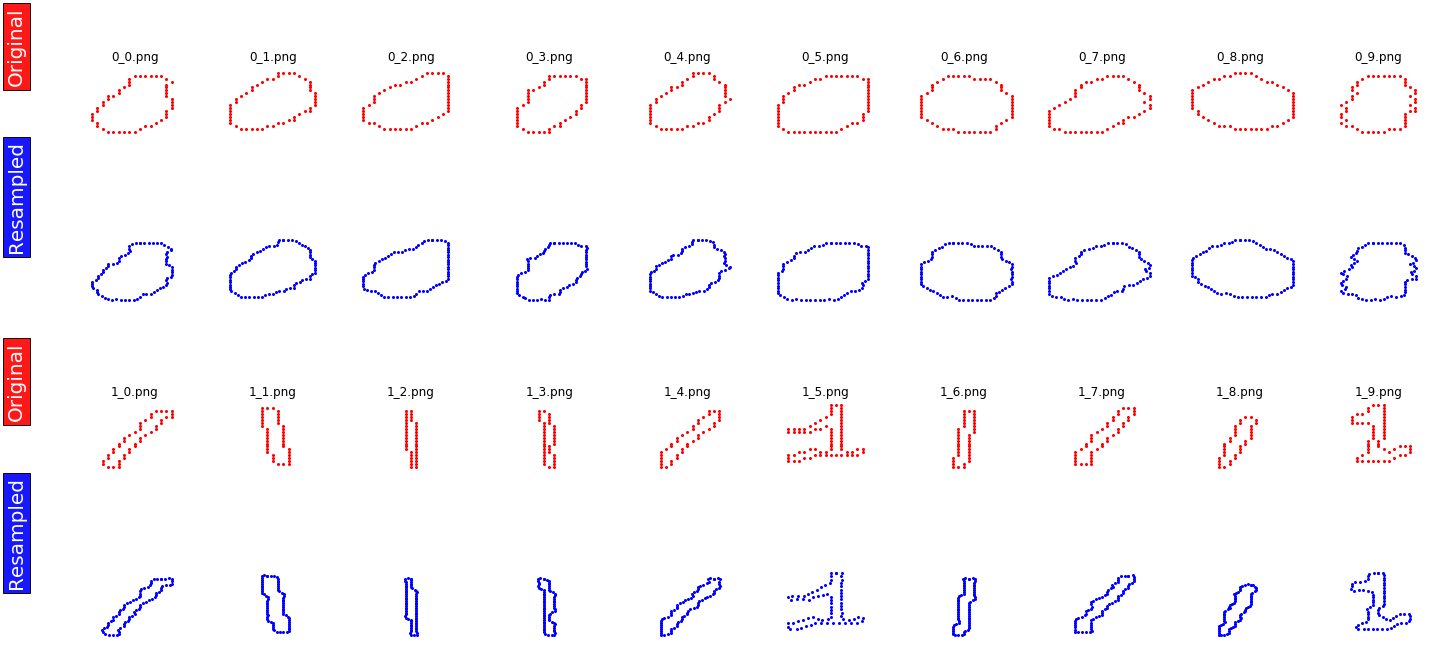

In [11]:
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 9))

j1 = 0
for ax, nm in zip(axes[0], zeros_names):
    ax.plot(Y_zeros_total[j1],X_zeros_total[j1], 'ro', markersize = 2)
    ax.axis('off')
    ax.set_title(nm)
    ax.set_xlim(2, 26)
    ax.set_ylim(2, 26)
    ax.invert_yaxis()
    if j1 == 0:
        ax.text(-10, 7, "Original",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=90,color='white')
    j1 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

j2 = 0
for ax, nm in zip(axes[1], zeros_names):
    ax.plot(y_zeros_sampled[j2],x_zeros_sampled[j2], 'bo', markersize = 2)
    ax.axis('off')
    #ax.set_title(nm)
    ax.set_xlim(2, 26)
    ax.set_ylim(2, 26)
    ax.invert_yaxis()
    if j2 == 0:
        ax.text(-10, 7, "Resampled",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=90,color='white')
    j2 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

k1 = 0
for ax, nm in zip(axes[2], ones_names):
    ax.plot(Y_ones_total[k1],X_ones_total[k1], 'ro', markersize = 2)
    ax.axis('off')
    ax.set_title(nm)
    ax.set_xlim(2, 26)
    ax.set_ylim(2, 26)
    ax.invert_yaxis()
    if k1 == 0:
        ax.text(-10, 7, "Original",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=90,color='white')
    k1 += 1
k2 = 0
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

for ax, nm in zip(axes[3], ones_names):
    ax.plot(y_ones_sampled[k2],x_ones_sampled[k2], 'bo', markersize = 2)
    ax.axis('off')
    #ax.set_title(nm)
    ax.set_xlim(2, 26)
    ax.set_ylim(2, 26)
    ax.invert_yaxis()
    if k2 == 0:
        ax.text(-10, 7, "Resampled",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=90,color='white')
    k2 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)
fig.tight_layout()

First the contour borders are transformed into complex borders.

In [12]:
complex_border_zeros_total=[]
for im_items in range(len(zeros_im)):
    complex_border_zeros=[]
    for border_numbers in range(len(x_zeros_sampled[im_items])):
        complex_border_zeros.append(complex(x_zeros_sampled[im_items][border_numbers],y_zeros_sampled[im_items][border_numbers]))
    complex_border_zeros_total.append(complex_border_zeros)

complex_border_ones_total=[]
for im_items in range(len(ones_im)):
    complex_border_ones=[]
    for border_numbers in range(len(x_ones_sampled[im_items])):
        complex_border_ones.append(complex(x_ones_sampled[im_items][border_numbers],y_ones_sampled[im_items][border_numbers]))
    complex_border_ones_total.append(complex_border_ones)

Then the fourier coefficients are calculated based on the transformed contours.


In [13]:
f0_zeros=[] # Amplitude of first fourier coefficient for ones
f1_zeros=[] # Amplitude of second fourier coefficient for ones
f2_zeros=[] # Amplitude of third fourier coefficient for ones
f3_zeros=[] # Amplitude of fourth fourier coefficient for ones
for im_items in range(len(zeros_im)): 
    f0_zeros.append(abs(np.fft.fft(complex_border_zeros_total[im_items])[0])) 
    f1_zeros.append(abs(np.fft.fft(complex_border_zeros_total[im_items])[1])) 
    f2_zeros.append(abs(np.fft.fft(complex_border_zeros_total[im_items])[2]))
    f3_zeros.append(abs(np.fft.fft(complex_border_zeros_total[im_items])[3])) 
    
    
f0_ones=[] # Amplitude of first fourier coefficient for ones
f1_ones=[] # Amplitude of second fourier coefficient for ones
f2_ones=[] # Amplitude of third fourier coefficient for ones
f3_ones=[] # Amplitude of fourth fourier coefficient for ones
for im_items in range(len(ones_im)):
    f0_ones.append(abs(np.fft.fft(complex_border_ones_total[im_items])[0]))
    f1_ones.append(abs(np.fft.fft(complex_border_ones_total[im_items])[1]))
    f2_ones.append(abs(np.fft.fft(complex_border_ones_total[im_items])[2]))
    f3_ones.append(abs(np.fft.fft(complex_border_ones_total[im_items])[3]))
    

Plotting the second ( | F1 | ) and third ( | F2 | ) Fourier magnitudes.

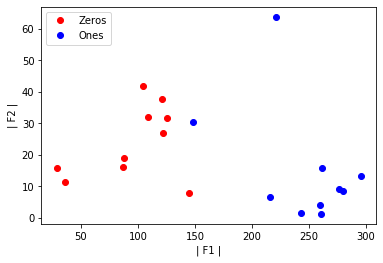

In [14]:
plt.plot(f1_zeros, f2_zeros, 'ro', f1_ones, f2_ones,'bo')
plt.xlabel('| F1 |')
plt.ylabel('| F2 |')
plt.legend(('Zeros', 'Ones'),
           loc='upper left')
plt.show()

Then, the scale invariant coefficients of the Fourier transform are calculated by dividing the 2nd and 3rd Fourier coefficients to the 1st coefficient:

In [15]:
f3_f0_zeros=[x/y for x, y in zip(f3_zeros, f0_zeros)]
f2_f0_zeros=[x/y for x, y in zip(f2_zeros, f0_zeros)]
f1_f0_zeros=[x/y for x, y in zip(f1_zeros, f0_zeros)]


f3_f0_ones=[x/y for x, y in zip(f3_ones, f0_ones)]
f2_f0_ones=[x/y for x, y in zip(f2_ones, f0_ones)]
f1_f0_ones=[x/y for x, y in zip(f1_ones, f0_ones)]

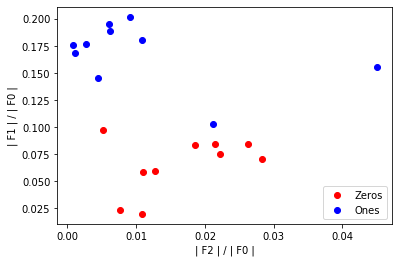

In [16]:
plt.plot(f2_f0_zeros, f1_f0_zeros, 'ro', f2_f0_ones, f1_f0_ones,'bo')
plt.xlabel('| F2 | / | F0 |')
plt.ylabel('| F1 | / | F0 |')
plt.legend(('Zeros', 'Ones'),
           loc='lower right')
plt.show()

#### 1.2.4 Rotation and Translation of Images
To investigate the effects of transformation on the image descriptors, random translations and rotations are applied to the images.

In [17]:
# define transformation functions
def rotFunc(inputImage):
    random.seed(5)
    rotated = []
    for item in range(len(inputImage)):
        rotated.append(rotate(inputImage[item], random.randint(0, 360)) > 0.5)
    return rotated

def transformFunc(inputImage):
    random.seed(10)
    translated = []
    for item in range(len(inputImage)):
        transX = random.randint(-2, 2)
        transY = random.randint(-2, 2)
        translated_tmp = SimilarityTransform(translation = (transX, transY))
        translated.append(warp(inputImage[item], translated_tmp) )
    return translated

Application of transformations:

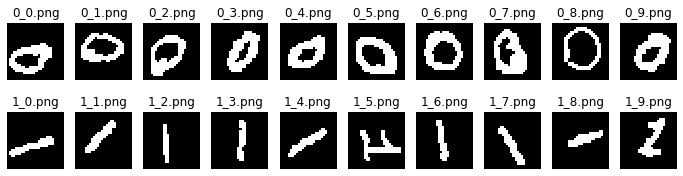

In [18]:
zeros_rotated = rotFunc(Opbinary_zeros)
ones_rotated = rotFunc(Opbinary_ones)    
    
zeros_rotated_translated = transformFunc(zeros_rotated)
ones_rotated_translated = transformFunc(ones_rotated)

Op_zeros_rotated_translated = []
for im_items in range(len(zeros_rotated_translated)):
    Op_zeros_rotated_translated.append(opening(zeros_rotated_translated[im_items], square(2)))

zeros_rotated_translated = Op_zeros_rotated_translated

Op_ones_rotated_translated = []
for im_items in range(len(ones_rotated_translated)):
    Op_ones_rotated_translated.append(opening(ones_rotated_translated[im_items], square(2)))

ones_rotated_translated = Op_ones_rotated_translated

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_rotated_translated, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_rotated_translated, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Finding the contours of transformed images:

In [19]:
tr_border_zeros=[]

for im_items in range(len(zeros_im)):
    tr_border_zeros.append(contour_tracking(zeros_rotated_translated[im_items]))
    
tr_border_ones=[]
for im_items in range(len(ones_im)):
    tr_border_ones.append(contour_tracking(ones_rotated_translated[im_items]))


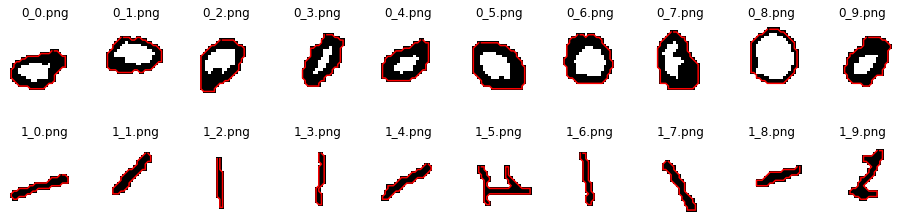

In [20]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(16, 4))
j = 0
for ax, im, nm in zip(axes[0], zeros_rotated_translated, zeros_names):
    ax.imshow(im, cmap='Greys')
    ax.plot([i[1] for i in tr_border_zeros[j]], [i[0] for i in tr_border_zeros[j]], 'r')
    ax.axis('off')
    ax.set_title(nm)
    j += 1
k = 0
for ax, im, nm in zip(axes[1], ones_rotated_translated, ones_names):
    ax.imshow(im, cmap='Greys')
    ax.plot([i[1] for i in tr_border_ones[k]], [i[0] for i in tr_border_ones[k]], 'r')
    ax.axis('off')
    ax.set_title(nm)
    k += 1

In [21]:
# Store X and Y coordinates of the boundaries of "ones" and "zeros" in separate lists

tr_X_zeros_total=[]
tr_Y_zeros_total=[]

for im_items in range(len(zeros_im)):
    tr_X_zeros=[]
    tr_Y_zeros=[]
    for border_numbers in range(len(tr_border_zeros[im_items])):
        tr_X_zeros.append(tr_border_zeros[im_items][border_numbers][0])
        tr_Y_zeros.append(tr_border_zeros[im_items][border_numbers][1])
    tr_X_zeros_total.append(tr_X_zeros)
    tr_Y_zeros_total.append(tr_Y_zeros)
    

tr_X_ones_total=[]
tr_Y_ones_total=[]

for im_items in range(len(ones_im)):
    tr_X_ones=[]
    tr_Y_ones=[]
    for border_numbers in range(len(tr_border_ones[im_items])):
        tr_X_ones.append(tr_border_ones[im_items][border_numbers][0])
        tr_Y_ones.append(tr_border_ones[im_items][border_numbers][1])
    tr_X_ones_total.append(tr_X_ones)
    tr_Y_ones_total.append(tr_Y_ones)

Fourier transformation:

In [22]:
# Create a new boundary signal with the defined length

tr_maxBorderLen = 0
for imageItem in range(len(zeros_im)):
    tr_maxBorderLen = max(tr_maxBorderLen, len(tr_border_zeros[imageItem]))
    tr_maxBorderLen = max(tr_maxBorderLen, len(tr_border_ones[imageItem]))

tr_x_zeros_sampled = []
tr_y_zeros_sampled = []
for imageItem in range(len(zeros_im)):
    tr_x = tr_X_zeros_total[imageItem]
    tr_y = tr_Y_zeros_total[imageItem]

    # append the starting x,y coordinates
    tr_x = np.r_[tr_x, tr_x[0]]
    tr_y = np.r_[tr_y, tr_y[0]]

    # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
    # is needed in order to force the spline fit to pass through all the input points.
    tr_tck, tr_u = interpolate.splprep([tr_x, tr_y], s=0, per=True)

    tr_xi, tr_yi = interpolate.splev(np.linspace(0, 1, tr_maxBorderLen), tr_tck)
    tr_x_zeros_sampled.append(tr_xi)
    tr_y_zeros_sampled.append(tr_yi)
    

tr_x_ones_sampled = []
tr_y_ones_sampled = []
for imageItem in range(len(ones_im)):
    tr_x = tr_X_ones_total[imageItem]
    tr_y = tr_Y_ones_total[imageItem]

    # append the starting x,y coordinates
    tr_x = np.r_[tr_x, tr_x[0]]
    tr_y = np.r_[tr_y, tr_y[0]]

    # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
    # is needed in order to force the spline fit to pass through all the input points.
    tr_tck, tr_u = interpolate.splprep([tr_x, tr_y], s=0, per=True)

    tr_xi, tr_yi = interpolate.splev(np.linspace(0, 1, tr_maxBorderLen), tr_tck)
    tr_x_ones_sampled.append(tr_xi)
    tr_y_ones_sampled.append(tr_yi)

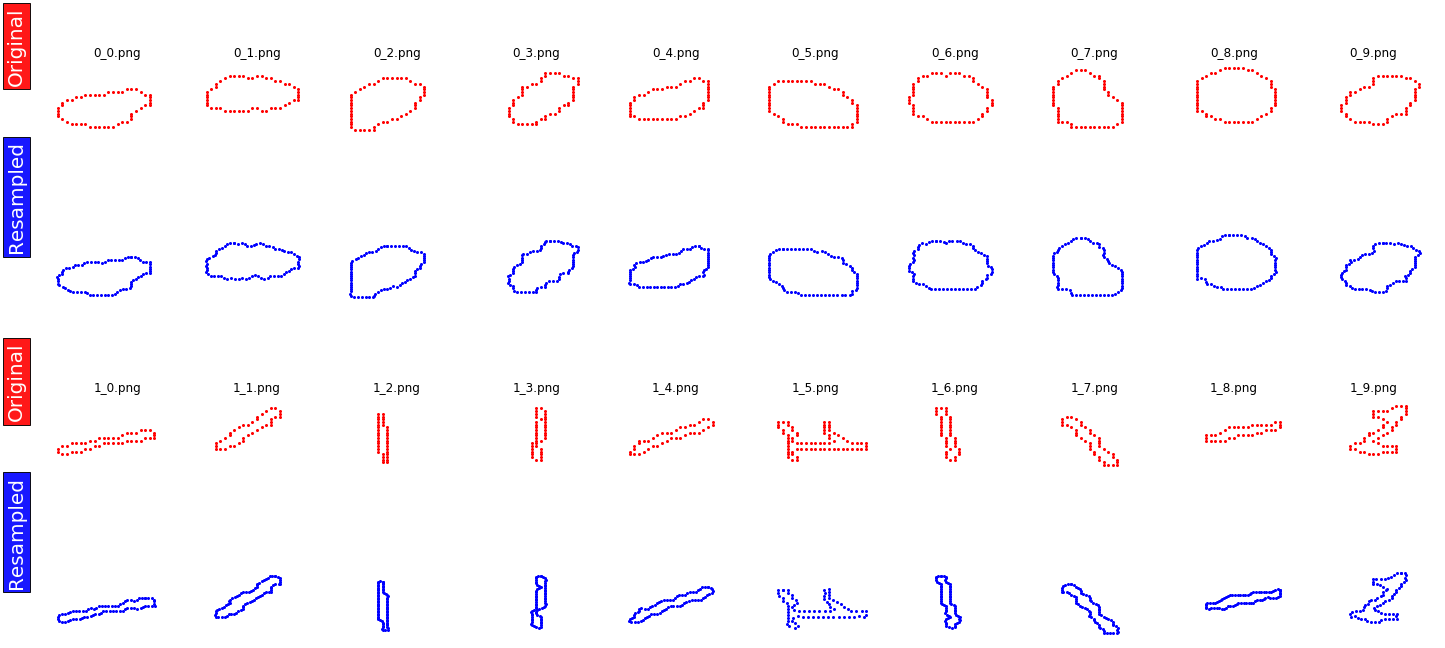

In [23]:
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 9))

j1 = 0
for ax, nm in zip(axes[0], zeros_names):
    ax.plot(tr_Y_zeros_total[j1], tr_X_zeros_total[j1], 'ro', markersize = 2)
    ax.axis('off')
    ax.set_title(nm)
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.invert_yaxis()
    if j1 == 0:
        ax.text(-10, 7, "Original",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=90,color='white')
    j1 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

j2 = 0
for ax, nm in zip(axes[1], zeros_names):
    ax.plot(tr_y_zeros_sampled[j2], tr_x_zeros_sampled[j2], 'bo', markersize = 2)
    ax.axis('off')
    #ax.set_title(nm)
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.invert_yaxis()
    if j2 == 0:
        ax.text(-10, 7, "Resampled",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=90,color='white')
    j2 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

k1 = 0
for ax, nm in zip(axes[2], ones_names):
    ax.plot(tr_Y_ones_total[k1], tr_X_ones_total[k1], 'ro', markersize = 2)
    ax.axis('off')
    ax.set_title(nm)
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.invert_yaxis()
    if k1 == 0:
        ax.text(-10, 7, "Original",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=90,color='white')
    k1 += 1
k2 = 0
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)

for ax, nm in zip(axes[3], ones_names):
    ax.plot(tr_y_ones_sampled[k2], tr_x_ones_sampled[k2], 'bo', markersize = 2)
    ax.axis('off')
    #ax.set_title(nm)
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.invert_yaxis()
    if k2 == 0:
        ax.text(-10, 7, "Resampled",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=90,color='white')
    k2 += 1
#plt.subplots_adjust(bottom=0.8, right=0.8, top=2)
fig.tight_layout()

In [24]:
tr_complex_border_zeros_total=[]
for im_items in range(len(zeros_im)):
    tr_complex_border_zeros=[]
    for border_numbers in range(len(x_zeros_sampled[im_items])):
        tr_complex_border_zeros.append(complex(tr_x_zeros_sampled[im_items][border_numbers], tr_y_zeros_sampled[im_items][border_numbers]))
    tr_complex_border_zeros_total.append(tr_complex_border_zeros)

tr_complex_border_ones_total=[]
for im_items in range(len(ones_im)):
    tr_complex_border_ones=[]
    for border_numbers in range(len(x_ones_sampled[im_items])):
        tr_complex_border_ones.append(complex(tr_x_ones_sampled[im_items][border_numbers], tr_y_ones_sampled[im_items][border_numbers]))
    tr_complex_border_ones_total.append(tr_complex_border_ones)

In [25]:
tr_f0_zeros=[] # Amplitude of first fourier coefficient for ones
tr_f1_zeros=[] # Amplitude of second fourier coefficient for ones
tr_f2_zeros=[] # Amplitude of third fourier coefficient for ones
tr_f3_zeros=[] # Amplitude of fourth fourier coefficient for ones
for im_items in range(len(zeros_im)): 
    tr_f0_zeros.append(abs(np.fft.fft(tr_complex_border_zeros_total[im_items])[0])) 
    tr_f1_zeros.append(abs(np.fft.fft(tr_complex_border_zeros_total[im_items])[1])) 
    tr_f2_zeros.append(abs(np.fft.fft(tr_complex_border_zeros_total[im_items])[2]))
    tr_f3_zeros.append(abs(np.fft.fft(tr_complex_border_zeros_total[im_items])[3])) 
    
    
tr_f0_ones=[] # Amplitude of first fourier coefficient for ones
tr_f1_ones=[] # Amplitude of second fourier coefficient for ones
tr_f2_ones=[] # Amplitude of third fourier coefficient for ones
tr_f3_ones=[] # Amplitude of fourth fourier coefficient for ones
for im_items in range(len(ones_im)):
    tr_f0_ones.append(abs(np.fft.fft(tr_complex_border_ones_total[im_items])[0]))
    tr_f1_ones.append(abs(np.fft.fft(tr_complex_border_ones_total[im_items])[1]))
    tr_f2_ones.append(abs(np.fft.fft(tr_complex_border_ones_total[im_items])[2]))
    tr_f3_ones.append(abs(np.fft.fft(tr_complex_border_ones_total[im_items])[3]))
    

Plotting features:

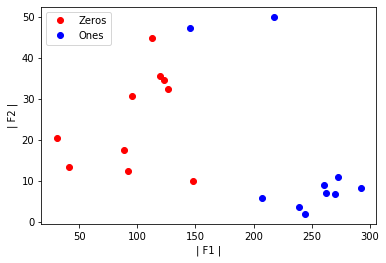

In [26]:
plt.plot(tr_f1_zeros, tr_f2_zeros, 'ro', tr_f1_ones, tr_f2_ones,'bo')
plt.xlabel('| F1 |')
plt.ylabel('| F2 |')
plt.legend(('Zeros', 'Ones'),
           loc='upper left')
plt.show()

As seen, the features are affected by the applied translations. To investigate the invariance of the feature ratios to rotation, the following procedure is carried out:

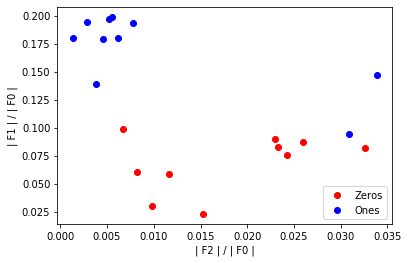

In [27]:
tr_f3_f0_zeros=[x/y for x, y in zip(tr_f3_zeros, tr_f0_zeros)]
tr_f2_f0_zeros=[x/y for x, y in zip(tr_f2_zeros, tr_f0_zeros)]
tr_f1_f0_zeros=[x/y for x, y in zip(tr_f1_zeros, tr_f0_zeros)]


tr_f3_f0_ones=[x/y for x, y in zip(tr_f3_ones, tr_f0_ones)]
tr_f2_f0_ones=[x/y for x, y in zip(tr_f2_ones, tr_f0_ones)]
tr_f1_f0_ones=[x/y for x, y in zip(tr_f1_ones, tr_f0_ones)]
plt.plot(tr_f2_f0_zeros, tr_f1_f0_zeros, 'ro', tr_f2_f0_ones, tr_f1_f0_ones,'bo')
plt.xlabel('| F2 | / | F0 |')
plt.ylabel('| F1 | / | F0 |')
plt.legend(('Zeros', 'Ones'),
           loc='lower right')
plt.show()

### 1.3 Additional Methods
Finally, a number of additional features are utilized for description of "ones" and "zeros".

Therefore, an image labeling procedure is performed as a pre-requisite for feature extraction.

##### Original Images

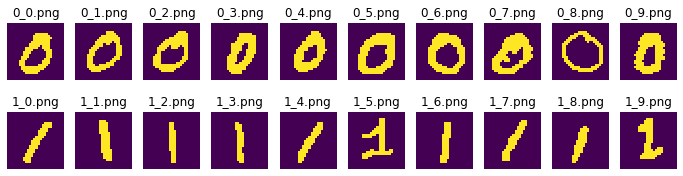

In [28]:
label_zeros=[]
image_label_overlay_zeros=[]
regions_zeros = []
label_zeros_filled=[]
image_label_overlay_zeros_filled=[]
regions_zeros_filled=[]
for im_items in range(len(zeros_im)):
    label_zeros.append(label(Opbinary_zeros[im_items]))
    image_label_overlay_zeros.append(label_zeros[im_items])
    regions_zeros.append(regionprops(label_zeros[im_items]))
    label_zeros_filled.append(label(binary_fill_holes(Opbinary_zeros[im_items])))
    image_label_overlay_zeros_filled.append(label_zeros_filled[im_items])
    regions_zeros_filled.append(regionprops(label_zeros_filled[im_items]))
    
label_ones=[]
image_label_overlay_ones=[]
regions_ones = []

for im_items in range(len(ones_im)):
    label_ones.append(label(Opbinary_ones[im_items]))
    image_label_overlay_ones.append(label_ones[im_items])
    regions_ones.append(regionprops(label_ones[im_items]))

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], image_label_overlay_zeros, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], image_label_overlay_ones, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)


##### Transformed Images

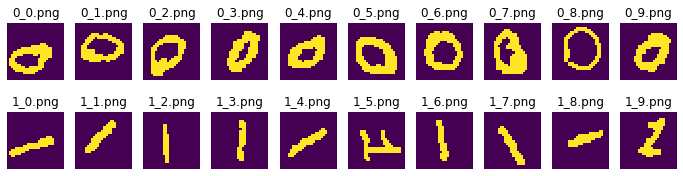

In [29]:
tr_label_zeros=[]
tr_image_label_overlay_zeros=[]
tr_regions_zeros = []
tr_label_zeros_filled=[]
tr_image_label_overlay_zeros_filled=[]
tr_regions_zeros_filled=[]
for im_items in range(len(zeros_im)):
    tr_label_zeros.append(label(Op_zeros_rotated_translated[im_items]))
    tr_image_label_overlay_zeros.append(tr_label_zeros[im_items])
    tr_regions_zeros.append(regionprops(tr_label_zeros[im_items]))
    tr_label_zeros_filled.append(label(binary_fill_holes(Op_zeros_rotated_translated[im_items])))
    tr_image_label_overlay_zeros_filled.append(tr_label_zeros_filled[im_items])
    tr_regions_zeros_filled.append(regionprops(tr_label_zeros_filled[im_items]))
    
tr_label_ones=[]
tr_image_label_overlay_ones=[]
tr_regions_ones = []

for im_items in range(len(ones_im)):
    tr_label_ones.append(label(Op_ones_rotated_translated[im_items]))
    tr_image_label_overlay_ones.append(tr_label_ones[im_items])
    tr_regions_ones.append(regionprops(tr_label_ones[im_items]))

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], tr_image_label_overlay_zeros, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], tr_image_label_overlay_ones, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)


Then, a number of features are extracted for both numbers:

##### Original Images

In [30]:
ratio_major_minor_zeros = []  #ratio of the length of major axis to minor axis
euler_number_zeros = []  #number of regions minus the number of holes
compactness_zeros = []  #the ratio of the area of an object to the area of a circle with the same perimeter

for im_items in range(len(zeros_im)):
    ratio_major_minor_zeros.append(regions_zeros[im_items][0].major_axis_length/regions_zeros[im_items][0].minor_axis_length)
    euler_number_zeros.append(regions_zeros[im_items][0].euler_number)
    compactness_zeros.append((4 * np.pi * regions_zeros_filled[im_items][0].area) / (regions_zeros_filled[im_items][0].perimeter ** 2))
    #compactness_zeros.append((4 * np.pi * regions_zeros[im_items][0].area) / (regions_zeros[im_items][0].perimeter) ** 2)

    
ratio_major_minor_ones=[]
euler_number_ones=[]
compactness_ones = []

for im_items in range(len(ones_im)):
    ratio_major_minor_ones.append(regions_ones[im_items][0].major_axis_length/regions_ones[im_items][0].minor_axis_length)
    euler_number_ones.append(regions_ones[im_items][0].euler_number)
    compactness_ones.append((4 * np.pi * regions_ones[im_items][0].area) /  (regions_ones[im_items][0].perimeter ** 2))
    #compactness_ones.append((4 * np.pi * regions_ones[im_items][0].area) / (regions_ones[im_items][0].perimeter) ** 2)

##### Transformed Images

In [31]:
tr_ratio_major_minor_zeros = []  #ratio of the length of major axis to minor axis
tr_euler_number_zeros = []  #number of regions minus the number of holes
tr_compactness_zeros = []  #the ratio of the area of an object to the area of a circle with the same perimeter

for im_items in range(len(zeros_im)):
    tr_ratio_major_minor_zeros.append(tr_regions_zeros[im_items][0].major_axis_length/tr_regions_zeros[im_items][0].minor_axis_length)
    tr_euler_number_zeros.append(tr_regions_zeros[im_items][0].euler_number)
    tr_compactness_zeros.append((4 * np.pi * tr_regions_zeros_filled[im_items][0].area) / (tr_regions_zeros_filled[im_items][0].perimeter ** 2))
    #compactness_zeros.append((4 * np.pi * regions_zeros[im_items][0].area) / (regions_zeros[im_items][0].perimeter) ** 2)

    
tr_ratio_major_minor_ones=[]
tr_euler_number_ones=[]
tr_compactness_ones = []

for im_items in range(len(ones_im)):
    tr_ratio_major_minor_ones.append(tr_regions_ones[im_items][0].major_axis_length/tr_regions_ones[im_items][0].minor_axis_length)
    tr_euler_number_ones.append(tr_regions_ones[im_items][0].euler_number)
    tr_compactness_ones.append((4 * np.pi * tr_regions_ones[im_items][0].area) /  (tr_regions_ones[im_items][0].perimeter ** 2))
    #compactness_ones.append((4 * np.pi * regions_ones[im_items][0].area) / (regions_ones[im_items][0].perimeter) ** 2)

#### 1.3.1. Euler Number vs Elongation Feature
Euler number is a feature invariant to translation, rotation and scaling. It is defined as the number of
components minus the number of holes. On the other hand, the elongation feature is the ratio of the length of major axis to minor axis.

It is assumed that the euler number for zeros and ones should be "0" and "1" and therefore it would be a good descriptor for classification. On the other hand, it can be somehow assumed that the elongation feature of the "ones" would be higher than "zeros".

##### Original Images vs Transformed Images

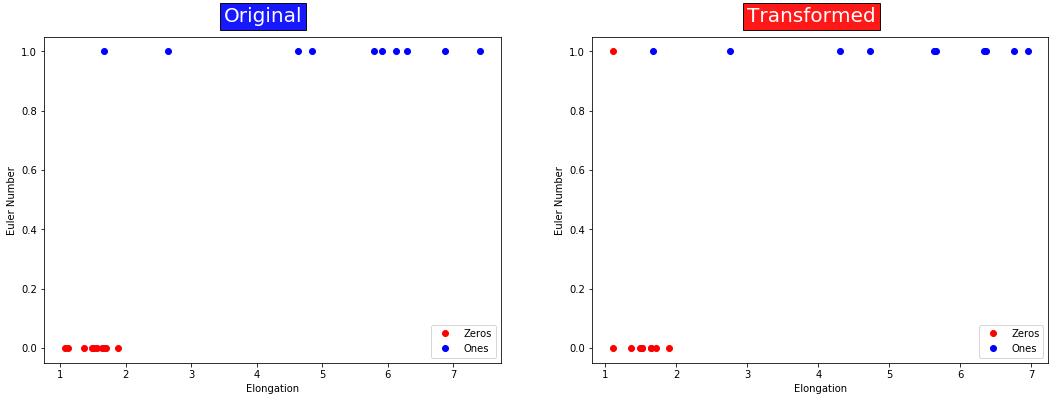

In [32]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(ratio_major_minor_zeros, euler_number_zeros, 'ro',  ratio_major_minor_ones,euler_number_ones,'bo')
ax[0].set_xlabel('Elongation')
ax[0].set_ylabel('Euler Number')
ax[0].legend(('Zeros', 'Ones'),
           loc='lower right')
ax[0].text(3.5, 1.1, "Original",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=0,color='white')

ax[1].plot(tr_ratio_major_minor_zeros, tr_euler_number_zeros, 'ro',  tr_ratio_major_minor_ones, tr_euler_number_ones,'bo')
ax[1].set_xlabel('Elongation')
ax[1].set_ylabel('Euler Number')
ax[1].legend(('Zeros', 'Ones'),
           loc='lower right')
ax[1].text(3., 1.1, "Transformed",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=0,color='white')

plt.show()

It can be seen that these two features are rotation and translation invariant.

#### 1.3.2. Compactness vs Elongation Feature
Compactness is the the ratio of the area of an object to the area of a circle with the same perimeter. The circle is the most compact object and has a maximum compactness value of 1. Because of the basic differences in the roundnes of "zero" and "one" objects, compactness seems a useful feature for the our problem.

##### Original Images vs Transformed Images

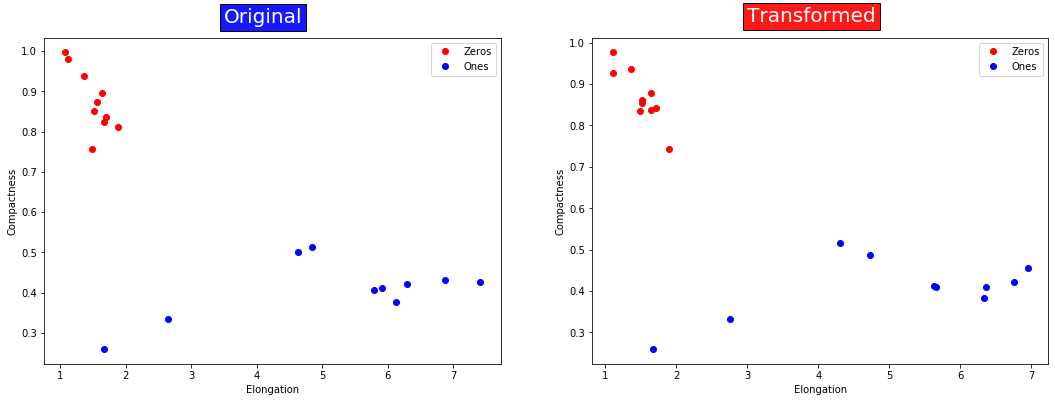

In [33]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(1, 2,figsize=(18, 6))

ax[0].plot(ratio_major_minor_zeros,compactness_zeros, 'ro', ratio_major_minor_ones,compactness_ones,'bo')
ax[0].set_xlabel('Elongation')
ax[0].set_ylabel('Compactness')
ax[0].legend(('Zeros', 'Ones'),
           loc='upper right')
ax[0].text(3.5, 1.07, "Original",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=0,color='white')

ax[1].plot(tr_ratio_major_minor_zeros, tr_compactness_zeros, 'ro', tr_ratio_major_minor_ones, tr_compactness_ones,'bo')
ax[1].set_xlabel('Elongation')
ax[1].set_ylabel('Compactness')
ax[1].legend(('Zeros', 'Ones'),
           loc='upper right')
ax[1].text(3., 1.05, "Transformed",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=0,color='white')


plt.show()

#### 1.3.3 3D space representation of features
Below, a 3D representation of the features is displayed. As seen, the "zeros" and "ones" are nicely distributed i the feature space, highlighting their proper definition and selection.

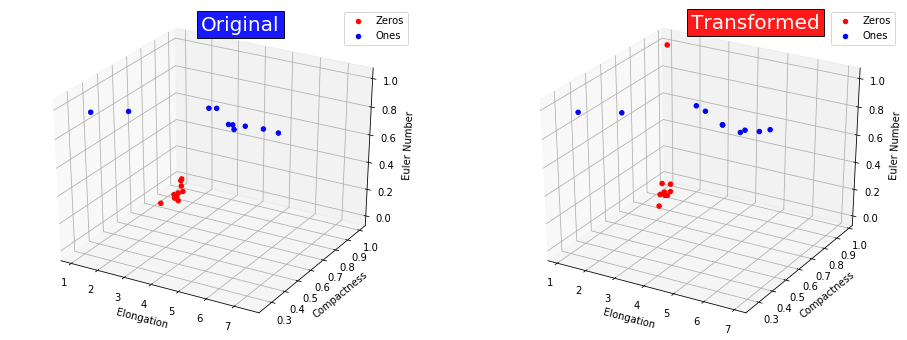

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2, projection='3d')

ax.scatter(ratio_major_minor_zeros,compactness_zeros,euler_number_zeros,color='red',alpha = 1 ,s=20)
ax.scatter(ratio_major_minor_ones,compactness_ones,euler_number_ones,color='blue',alpha = 1,s=20)

ax1.scatter(tr_ratio_major_minor_zeros,tr_compactness_zeros,tr_euler_number_zeros,color='red',alpha = 1,s=20)
ax1.scatter(tr_ratio_major_minor_ones,tr_compactness_ones,tr_euler_number_ones,color='blue',alpha = 1,s=20)

ax.set_xlabel('Elongation')
ax.set_ylabel('Compactness')
ax.set_zlabel('Euler Number')
ax.legend(('Zeros', 'Ones'),
           loc='upper right')
ax.text(1.5, 1.07,1.08, "Original",fontsize=20,bbox=dict(facecolor='blue', alpha=0.9),rotation=0,color='white')

ax1.set_xlabel('Elongation')
ax1.set_ylabel('Compactness')
ax1.set_zlabel('Euler Number')
ax1.legend(('Zeros', 'Ones'),
           loc='upper right')
ax1.text(1.5, 1.07,1.08, "Transformed",fontsize=20,bbox=dict(facecolor='red', alpha=0.9),rotation=0,color='white')

plt.show()